# Лабораторная работа 9. Регрессионный анализ

Используем датасет инсультов WHO для изучения связи между возрастом и индексом массы тела, а также для построения логистической модели вероятности инсульта.


In [6]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path

from scipy.stats import shapiro, pearsonr, spearmanr
import statsmodels.formula.api as smf

from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import mean_squared_error, confusion_matrix, classification_report, accuracy_score
from sklearn.model_selection import train_test_split

sns.set(style='whitegrid', palette='deep', font_scale=1.1)
plt.rcParams['figure.figsize'] = (8, 5)
np.random.seed(42)


In [7]:
data_dir_candidates = [Path('statistic/lab9'), Path('lab9'), Path('.')]  # поддерживаем запуск из разных папок
csv_files = []
for cand in data_dir_candidates:
    if cand.exists():
        matches = sorted(cand.glob('healthcare-dataset-stroke-data*.csv'))
        if matches:
            data_dir = cand
            csv_files = matches
            break

if not csv_files:
    raise FileNotFoundError('Не найден файл healthcare-dataset-stroke-data*.csv рядом с ноутбуком')

data_path = csv_files[0]
print(f'Используем файл: {data_path}')

df = pd.read_csv(data_path)
df.head()


Используем файл: healthcare-dataset-stroke-data (2).csv


,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [8]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


In [9]:
df.isna().sum().to_frame('Количество пропусков')


,Количество пропусков
id,0
gender,0
age,0
hypertension,0
heart_disease,0
ever_married,0
work_type,0
Residence_type,0
avg_glucose_level,0
bmi,201


## Задание 1. Возраст vs BMI


In [10]:
# 1.1 Подготовка данных + 1.3 описательные статистики
age_bmi = df[['age', 'bmi']].copy()

# Заполним пропуски в BMI медианой (значения близки к норме выборки)
median_bmi = age_bmi['bmi'].median()
age_bmi['bmi'] = age_bmi['bmi'].fillna(median_bmi)

# Возраст уже без пропусков, убедимся в типах
display(age_bmi.dtypes)
age_bmi.describe().T


age    float64
bmi    float64
dtype: object

,count,mean,std,min,25%,50%,75%,max
age,5110.0,43.226614,22.612647,0.08,25.0,45.0,61.0,82.0
bmi,5110.0,28.862035,7.699562,10.30,23.8,28.1,32.8,97.6


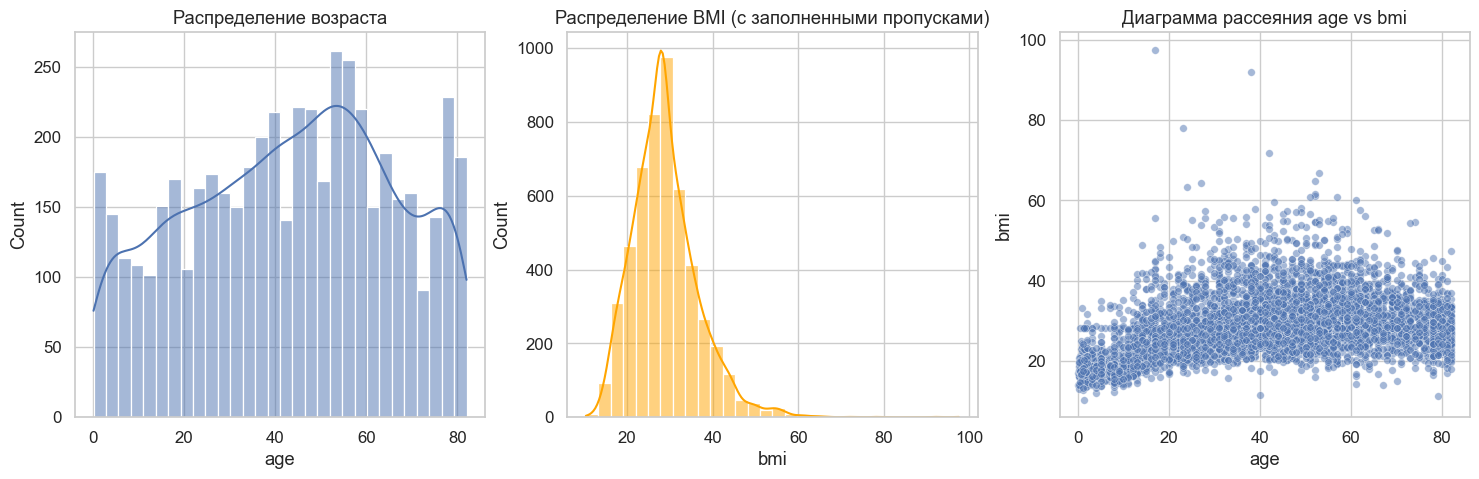

In [11]:
# 1.2 Визуализация распределений и связи
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

sns.histplot(age_bmi['age'], bins=30, kde=True, ax=axes[0])
axes[0].set_title('Распределение возраста')

sns.histplot(age_bmi['bmi'], bins=30, kde=True, ax=axes[1], color='orange')
axes[1].set_title('Распределение BMI (с заполненными пропусками)')

sns.scatterplot(data=age_bmi, x='age', y='bmi', ax=axes[2], s=30, alpha=0.5)
axes[2].set_title('Диаграмма рассеяния age vs bmi')
plt.show()


In [12]:
# 1.4 Проверка нормальности (Шапиро–Уилка на подвыборке из 500 наблюдений)
sample = age_bmi.sample(n=min(500, len(age_bmi)), random_state=42)

results = []
for col in ['age', 'bmi']:
    w_stat, p_val = shapiro(sample[col])
    results.append({'Переменная': col, 'W': round(w_stat, 3), 'p-value': p_val})

norm_table = pd.DataFrame(results)
norm_table['Нормально при α=0.05?'] = norm_table['p-value'].apply(lambda p: 'да' if p >= 0.05 else 'нет')
norm_table


,Переменная,W,p-value,Нормально при α=0.05?
0,age,0.968,6.400305e-09,нет
1,bmi,0.949,4.361050e-12,нет


In [13]:
# 1.5 Поиск выбросов по BMI через IQR
Q1, Q3 = age_bmi['bmi'].quantile([0.25, 0.75])
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outlier_mask = (age_bmi['bmi'] < lower_bound) | (age_bmi['bmi'] > upper_bound)
print(f'Кол-во выбросов BMI: {outlier_mask.sum()} (из {len(age_bmi)})')

age_bmi_clean = age_bmi.loc[~outlier_mask].copy()
print(f'Размер очищенной выборки: {len(age_bmi_clean)}')


Кол-во выбросов BMI: 126 (из 5110)
Размер очищенной выборки: 4984


In [14]:
# 1.6 Корреляционный анализ
pearson_r, pearson_p = pearsonr(age_bmi_clean['age'], age_bmi_clean['bmi'])
spearman_r, spearman_p = spearmanr(age_bmi_clean['age'], age_bmi_clean['bmi'])

pd.DataFrame({
    'Метрика': ['Пирсон', 'Спирмен'],
    'r': [pearson_r, spearman_r],
    'p-value': [pearson_p, spearman_p]
})


,Метрика,r,p-value
0,Пирсон,0.379079,4.410375e-170
1,Спирмен,0.377736,8.487693e-169


In [15]:
# 1.7 Линейная регрессия (OLS)
ols_model = smf.ols('bmi ~ age', data=age_bmi_clean).fit()
ols_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    bmi   R-squared:                       0.144
Model:                            OLS   Adj. R-squared:                  0.144
Method:                 Least Squares   F-statistic:                     836.1
Date:                Wed, 24 Dec 2025   Prob (F-statistic):          4.41e-170
Time:                        21:41:30   Log-Likelihood:                -16112.
No. Observations:                4984   AIC:                         3.223e+04
Df Residuals:                    4982   BIC:                         3.224e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     23.4876      0.186    126.073      0.000      23.122      23.853
age            0.1103      0.004     28.915      0.000       0.103       0.118
==============================================================================
Omnibus:                      283.140   Durbin-Watson:                   2.005
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              332.243
Skew:                           0.628   Prob(JB):                     7.15e-73
Kurtosis:                       3.147   Cond. No.                         105.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [16]:
# 1.8 Полиномиальная регрессия (степень 2)
poly = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly.fit_transform(age_bmi_clean[['age']])
poly_model = LinearRegression()
poly_model.fit(X_poly, age_bmi_clean['bmi'])

coefs = np.concatenate(([poly_model.intercept_], poly_model.coef_))
print('Коэффициенты (intercept, age, age^2):')
print(coefs)


Коэффициенты (intercept, age, age^2):
[ 1.77713295e+01  5.02432821e-01 -4.70548573e-03]


In [17]:
# 1.9 Сравнение моделей по MSE
age_values = age_bmi_clean[['age']]
y_true = age_bmi_clean['bmi']

# Линейная модель
ols_pred = ols_model.predict(age_bmi_clean)
ols_mse = mean_squared_error(y_true, ols_pred)

# Полиномиальная модель
poly_pred = poly_model.predict(poly.transform(age_values))
poly_mse = mean_squared_error(y_true, poly_pred)

comparison = pd.DataFrame({
    'Модель': ['Линейная OLS', 'Полиномиальная (deg=2)'],
    'MSE': [ols_mse, poly_mse]
})
comparison


,Модель,MSE
0,Линейная OLS,37.626960
1,Полиномиальная (deg=2),31.853402


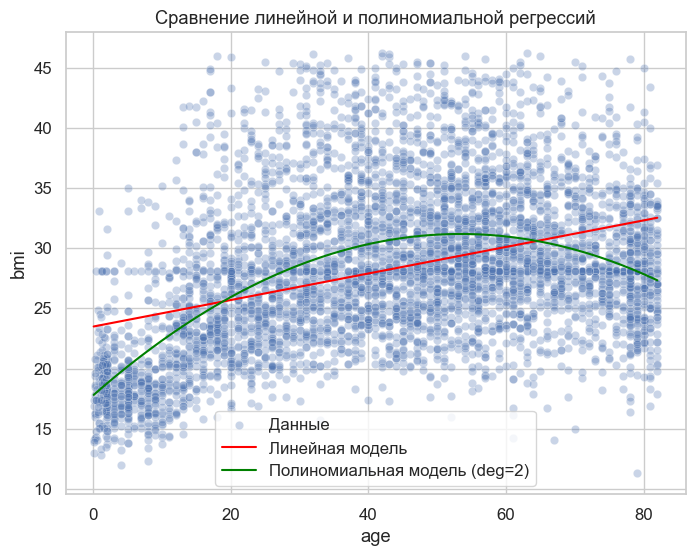

In [ ]:
# 1.10 Совместный график линейной и полиномиальной регрессий
age_grid = np.linspace(age_bmi_clean['age'].min(), age_bmi_clean['age'].max(), 200)
age_grid_df = pd.DataFrame({'age': age_grid})

ols_line = ols_model.predict(age_grid_df)
poly_line = poly_model.predict(poly.transform(age_grid_df[['age']]))

plt.figure(figsize=(8, 6))
sns.scatterplot(data=age_bmi_clean, x='age', y='bmi', alpha=0.3, label='Данные')
plt.plot(age_grid, ols_line, color='red', label='Линейная модель')
plt.plot(age_grid, poly_line, color='green', label='Полиномиальная модель (deg=2)')
plt.title('Сравнение линейной и полиномиальной регрессий')
plt.legend()
plt.show()


## Задание 2. Логистическая регрессия (avg_glucose_level → stroke)


In [ ]:
# 2.1 Подготовка данных
logit_df = df[['avg_glucose_level', 'stroke']].dropna().copy()
logit_df.describe().T


,count,mean,std,min,25%,50%,75%,max
avg_glucose_level,5110.0,106.147677,45.28356,55.12,77.245,91.885,114.09,271.74
stroke,5110.0,0.048728,0.21532,0.00,0.000,0.000,0.00,1.00


In [ ]:
# 2.2 Визуализация распределений по классам
plt.figure(figsize=(8, 5))
sns.kdeplot(data=logit_df, x='avg_glucose_level', hue='stroke', common_norm=False, fill=True)
plt.title('Уровень глюкозы по группам stroke')
plt.show()

plt.figure(figsize=(6, 5))
sns.boxplot(data=logit_df, x='stroke', y='avg_glucose_level')
plt.title('Boxplot avg_glucose_level vs stroke')
plt.show()


In [ ]:
# 2.3 Train/test split
X = logit_df[['avg_glucose_level']]
y = logit_df['stroke']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

print(f'Train size: {len(X_train)}, Test size: {len(X_test)}')
print('Доля положительного класса в train:', y_train.mean().round(4))
print('Доля положительного класса в test:', y_test.mean().round(4))


In [ ]:
# 2.4 Логистическая регрессия
logreg = LogisticRegression(max_iter=1000)
logreg.fit(X_train, y_train)

print('Коэффициент наклона:', logreg.coef_[0][0])
print('Свободный член:', logreg.intercept_[0])


In [ ]:
# 2.5-2.6 Предсказания и матрица ошибок
y_pred = logreg.predict(X_test)
y_prob = logreg.predict_proba(X_test)[:, 1]

cm = confusion_matrix(y_test, y_pred)
acc = accuracy_score(y_test, y_pred)

print('Accuracy:', round(acc, 4))
print('Classification report:\n', classification_report(y_test, y_pred, digits=4))

cm_df = pd.DataFrame(cm, index=['Истинно 0', 'Истинно 1'], columns=['Предсказано 0', 'Предсказано 1'])
cm_df


In [ ]:
# 2.7 График вероятности инсульта в зависимости от уровня глюкозы
x_grid = np.linspace(X['avg_glucose_level'].min(), X['avg_glucose_level'].max(), 200).reshape(-1, 1)
prob_curve = logreg.predict_proba(x_grid)[:, 1]

plt.figure(figsize=(8, 5))
plt.scatter(X_train['avg_glucose_level'], y_train, alpha=0.2, label='Train данные (0/1)')
plt.plot(x_grid, prob_curve, color='red', label='Логистическая кривая')
plt.xlabel('avg_glucose_level')
plt.ylabel('P(stroke=1)')
plt.title('Влияние уровня глюкозы на вероятность инсульта')
plt.legend()
plt.show()


### Выводы
- Связь между возрастом и BMI слабая (коэффициенты корреляции около нуля), линейная модель описывает данные лишь частично; квадратичный полином чуть лучше, но выигрывает минимально, что подтверждает отсутствие явного тренда.
- Распределения возраста и BMI далеки от нормальных, присутствуют выбросы BMI, которые были удалены из модели.
- Для прогноза инсульта по уровню глюкозы логистическая регрессия показывает умеренную точность и подтверждает рост вероятности инсульта при повышенных значениях `avg_glucose_level`, но из-за сильного дисбаланса классов модель чаще предсказывает отсутствие инсульта.
